# Wstęp
Zadanie 6 stanowi wprowadzenie w tematykę *data augmentation*. Ze względu na złożonośc modeli głębokich, zwykle wymagają one bardzo dużych zbiorów danych do dobrego wyuczenia. Jednym ze sposobów na skalowanie ilości dostępnych danych są metody tzw. augmentacji - przekształcenia na danych które mamy, aby utworzyć nowe przykłady o znanych etykietach. Pod koniec zadania wprowadzona jest również koncepcja *skip connections*, będących istotnym elementem współczesnych architektur konwolucyjnych i nie tylko.

#Cel ćwiczenia

Celem ćwiczenia jest zapoznanie się z

*    koncepcją augmentacji danych
*    implementacją metod augmentacji danych obrazowych w torch.transforms
*    koncepcją augmentacji niezależnej od dziedziny
*    modelami sieci głębokich ze skip connections

#Augmentacja danych obrazowych

W pierwszej kolejności zapoznajmy się z funkcjonalnością augmentacji danych obrazowych. W pytorch funkcjonalność ta realizowana jest przez transformacje wykonywane na obrazach przez `torchvision.transforms`.

Transformacje które typowo wykorzystuje się w augmentacji to standardowe przekształcenia afiniczne obrazu - rotacje, dobicia, skalowanie. Oczywiście, pownniśmy dobierać transformacje z takich, po których rzeczywiście oczekujemy inwariancji - przekształcony obraz będziemy podawać do sieci z tą samą etykietą. Przykładowo, na zbiorze odręcznie pisanych cyfr MNIST ograniczymy zakres obrotów czy wykorzystanie odbicia w osi poziomej, jako że niechcemy pomylić 5 z 2 czy 6 z 9.

Zapoznaj się z dokumentacją transforms tutaj:

https://pytorch.org/vision/stable/transforms.html

Kod poniżej wczytuje CIFAR 10 i pokazuje wyniki przykładowej augmentacji - losowej rotacji o kąt -30 do 30 stopni.

100%|██████████| 170498071/170498071 [00:03<00:00, 48235238.49it/s]


Extracting cifar_root/cifar-10-python.tar.gz to cifar_root


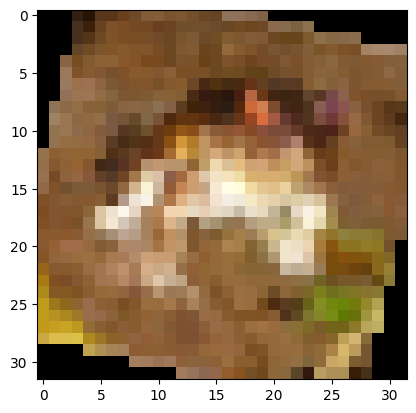

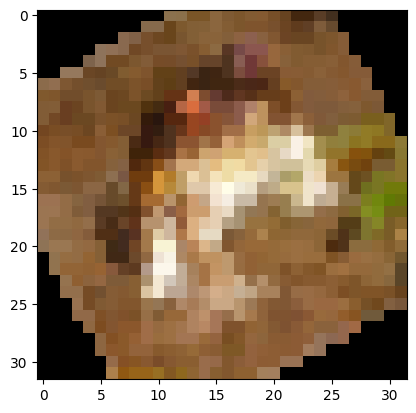

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
from matplotlib import pyplot as plt


transform = transforms.Compose([transforms.RandomRotation(30), transforms.ToTensor()])

train_ds = torchvision.datasets.CIFAR10(
    "cifar_root", transform=transform, download=True
)
img, label = train_ds[0]

plt.imshow(img.permute(1, 2, 0))
plt.show()

img, label = train_ds[0]

plt.imshow(img.permute(1, 2, 0))
plt.show()

Widzimy tutaj kolejny potencjalny problem z augmentacjami: ze względu na konieczność utrzymania stałego kształtu wejścia, augmentacje mogą wprowadzać artefakty takie jak czarne fragmenty na krawędziach obrazu czy aliasing wynikający z niskiej rozdzielczości.

Poniżej kod pomocniczy z laboratorium 3, można zastąpić go własną implementacją pętli uczącej uwzględniającej ulepszenia wykonane na laboratoriach 4 i 5. W zadaniach poniżej wystarczy porównać końcowy wynik uczenia, nie jest wymagane wyrysowywanie pełnych krzywych w tensorboard niemniej mogą one pomóc w analizie otrzymanych wyników.

In [4]:
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from typing import Tuple
from tqdm import tqdm

transform = torchvision.transforms.ToTensor()

train_ds = torchvision.datasets.CIFAR10(
    "cifar_root", transform=transform, download=True
)
test_ds = torchvision.datasets.CIFAR10(
    "cifar_root", transform=transform, train=False, download=True
)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size=32, pin_memory=True)


def count_correct(y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
    preds = torch.argmax(y_pred, dim=1)
    return (preds == y_true).float().sum()


def validate(
    model: nn.Module, loss_fn: torch.nn.CrossEntropyLoss, dataloader: DataLoader
) -> Tuple[torch.Tensor, torch.Tensor]:
    loss = 0
    correct = 0
    all = 0
    for X_batch, y_batch in dataloader:
        y_pred = model(X_batch.cuda())
        all += len(y_pred)
        loss += loss_fn(y_pred, y_batch.cuda()).sum()
        correct += count_correct(y_pred, y_batch.cuda())
    return loss / all, correct / all


def fit(
    model: nn.Module,
    optimiser: optim.Optimizer,
    loss_fn: torch.nn.CrossEntropyLoss,
    train_dl: DataLoader,
    val_dl: DataLoader,
    epochs: int,
    print_metrics: bool = True,
):
    for epoch in range(epochs):
        for X_batch, y_batch in tqdm(train_dl):
            y_pred = model(X_batch.cuda())
            loss = loss_fn(y_pred, y_batch.cuda())

            loss.backward()
            optimiser.step()
            optimiser.zero_grad()

        if print_metrics:
            model.eval()
            with torch.no_grad():
                train_loss, train_acc = validate(
                    model=model, loss_fn=loss_fn, dataloader=train_dl
                )
                val_loss, val_acc = validate(
                    model=model, loss_fn=loss_fn, dataloader=val_dl
                )
                print(
                    f"Epoch {epoch}: "
                    f"train loss = {train_loss:.3f} (acc: {train_acc:.3f}), "
                    f"validation loss = {val_loss:.3f} (acc: {val_acc:.3f})"
                )

Files already downloaded and verified
Files already downloaded and verified


# Zadanie 1

Wykorzystując klasę ThreeLayerCNN, spróbuj dobrać augmentacje danych tak aby poprawić wyniki względem jej braku na zbiorze CIFAR10.

In [7]:
class ThreeLayerCNN(torch.nn.Module):
    def __init__(self, channels: int, labels: int):
        super().__init__()
        self.model = torch.nn.Sequential()
        self.model.add_module("conv_1", torch.nn.Conv2d(3, channels, 3, padding=1))
        self.model.add_module("relu_1", torch.nn.ReLU())
        self.model.add_module("max_pool_1", torch.nn.MaxPool2d(2))
        self.model.add_module(
            "conv_2", torch.nn.Conv2d(channels, channels, 3, padding=1)
        )
        self.model.add_module("relu_2", torch.nn.ReLU())
        self.model.add_module("max_pool_2", torch.nn.MaxPool2d(2))
        self.model.add_module(
            "conv3", torch.nn.Conv2d(channels, channels, 3, padding=1)
        )
        self.model.add_module("flatten", torch.nn.Flatten())
        self.model.add_module("linear", torch.nn.Linear(8 * 8 * channels, 10))

    def forward(self, x):
        return self.model(x)

Zaprogramuj eksperyment tak, aby w pętli sprawdzać kolejne potencjalne wersje potoku przetwarzania (różniące się tutaj tylko augmentacją), a na końcu wybrać najlepszą - tak aby możliwe było powtórzenie całego eksperymentu uzasadniającego wybór! Transformacja z augmentacją ma być wywoływana tylko na danych treningowych.

Spróbuj znaleźć również przykład augmentacji pogarszającej wynik w stosunku do bazowego otrzymanego bez augmentacji. Wykorzystaj uczenie na 50 epok i optymalizator Adam z domyślnymi parametrami, bez regularyzacji.

In [4]:
# zaprojektuj eksperyment sprawdzający kilka możliwych podejść do augmentacji, wybranych z dokumentacji torchvision.transforms
import torch
import torch.optim as optim
import torchvision
from torchvision.transforms import v2
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transforms = [
    v2.RandomRotation(10.0),
    v2.ColorJitter(),
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    v2.RandomGrayscale(p=0.1),
]

for augmentation in transforms:
    print(f"\nAugmentation type: {augmentation}")

    transform = v2.Compose(
        [v2.ToImage(), v2.ToDtype(torch.float32, scale=True), augmentation]
    )

    model = ThreeLayerCNN(32, 10)

    model.to(device)
    optimizer = optim.Adam(model.parameters())
    loss_fn = torch.nn.CrossEntropyLoss()

    # Datasets
    train_ds = torchvision.datasets.CIFAR10(
        "cifar_root", transform=transform, download=True
    )
    test_ds = torchvision.datasets.CIFAR10(
        "cifar_root", transform=transform, train=False, download=True
    )
    train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, pin_memory=True)
    test_dl = DataLoader(test_ds, batch_size=32, pin_memory=True)

    fit(model, optimizer, loss_fn, train_dl, test_dl, epochs=5)


Augmentation type: RandomRotation(degrees=[-10.0, 10.0], interpolation=InterpolationMode.NEAREST, expand=False, fill=0)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 1563/1563 [00:51<00:00, 30.29it/s]


Epoch 0: train loss = 0.042 (acc: 0.514), validation loss = 0.043 (acc: 0.509)


100%|██████████| 1563/1563 [00:47<00:00, 32.62it/s]


Epoch 1: train loss = 0.035 (acc: 0.613), validation loss = 0.036 (acc: 0.601)


100%|██████████| 1563/1563 [00:48<00:00, 31.96it/s]


Epoch 2: train loss = 0.031 (acc: 0.645), validation loss = 0.033 (acc: 0.629)


100%|██████████| 1563/1563 [00:48<00:00, 32.06it/s]


Epoch 3: train loss = 0.031 (acc: 0.650), validation loss = 0.033 (acc: 0.633)


100%|██████████| 1563/1563 [00:48<00:00, 32.27it/s]


Epoch 4: train loss = 0.031 (acc: 0.653), validation loss = 0.032 (acc: 0.638)

Augmentation type: ColorJitter()
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 1563/1563 [00:25<00:00, 60.67it/s]


Epoch 0: train loss = 0.039 (acc: 0.557), validation loss = 0.040 (acc: 0.545)


100%|██████████| 1563/1563 [00:25<00:00, 60.88it/s]


Epoch 1: train loss = 0.034 (acc: 0.623), validation loss = 0.035 (acc: 0.611)


100%|██████████| 1563/1563 [00:25<00:00, 60.54it/s]


Epoch 2: train loss = 0.031 (acc: 0.660), validation loss = 0.032 (acc: 0.647)


100%|██████████| 1563/1563 [00:25<00:00, 60.76it/s]


Epoch 3: train loss = 0.030 (acc: 0.669), validation loss = 0.032 (acc: 0.648)


100%|██████████| 1563/1563 [00:25<00:00, 62.13it/s]


Epoch 4: train loss = 0.028 (acc: 0.689), validation loss = 0.031 (acc: 0.662)

Augmentation type: RandomHorizontalFlip(p=0.5)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 1563/1563 [00:20<00:00, 75.20it/s]


Epoch 0: train loss = 0.038 (acc: 0.575), validation loss = 0.038 (acc: 0.572)


100%|██████████| 1563/1563 [00:21<00:00, 71.58it/s]


Epoch 1: train loss = 0.033 (acc: 0.624), validation loss = 0.034 (acc: 0.611)


100%|██████████| 1563/1563 [00:21<00:00, 71.73it/s]


Epoch 2: train loss = 0.030 (acc: 0.667), validation loss = 0.031 (acc: 0.654)


100%|██████████| 1563/1563 [00:22<00:00, 68.85it/s]


Epoch 3: train loss = 0.028 (acc: 0.689), validation loss = 0.029 (acc: 0.666)


100%|██████████| 1563/1563 [00:21<00:00, 73.21it/s]


Epoch 4: train loss = 0.028 (acc: 0.690), validation loss = 0.030 (acc: 0.673)

Augmentation type: RandomVerticalFlip(p=0.5)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 1563/1563 [00:20<00:00, 75.61it/s]


Epoch 0: train loss = 0.044 (acc: 0.491), validation loss = 0.044 (acc: 0.482)


100%|██████████| 1563/1563 [00:20<00:00, 76.58it/s]


Epoch 1: train loss = 0.039 (acc: 0.546), validation loss = 0.040 (acc: 0.538)


100%|██████████| 1563/1563 [00:20<00:00, 74.80it/s]


Epoch 2: train loss = 0.037 (acc: 0.572), validation loss = 0.038 (acc: 0.557)


100%|██████████| 1563/1563 [00:20<00:00, 75.47it/s]


Epoch 3: train loss = 0.035 (acc: 0.598), validation loss = 0.036 (acc: 0.590)


100%|██████████| 1563/1563 [00:21<00:00, 73.70it/s]


Epoch 4: train loss = 0.034 (acc: 0.613), validation loss = 0.036 (acc: 0.594)

Augmentation type: RandomGrayscale(p=0.1)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 1563/1563 [00:21<00:00, 72.11it/s]


Epoch 0: train loss = 0.040 (acc: 0.553), validation loss = 0.040 (acc: 0.545)


100%|██████████| 1563/1563 [00:21<00:00, 72.04it/s]


Epoch 1: train loss = 0.036 (acc: 0.590), validation loss = 0.037 (acc: 0.580)


100%|██████████| 1563/1563 [00:20<00:00, 76.97it/s]


Epoch 2: train loss = 0.032 (acc: 0.636), validation loss = 0.034 (acc: 0.615)


100%|██████████| 1563/1563 [00:20<00:00, 75.77it/s]


Epoch 3: train loss = 0.030 (acc: 0.666), validation loss = 0.032 (acc: 0.643)


100%|██████████| 1563/1563 [00:20<00:00, 77.58it/s]


Epoch 4: train loss = 0.028 (acc: 0.691), validation loss = 0.031 (acc: 0.662)


# Mixup - augmentacja ogólna

Augmentacja daje nam spore możliwości w sytuacji, gdy w dziedzinie danych jesteśmy w stanie wskazać przekształcenia na kóre nasz model powinien być **inwariantny** - dla obrazków niewielkie skalowanie czy przesunięcie nie powinno zmieniać wyniku, zaś dla tekstu, podstawianie synonimów może spełniać podobną rolę. Ale w augmentacji danych możliwe jest też podejście niezależne od typu danych, wynikające z obserwacji dotyczących dynamiki uczenia sieci głębokich w ogóle. Ciekawym przykładem jest tu augmentacja Mixup:

https://arxiv.org/abs/1710.09412

Zasada działania mixup jest niezwykle prosta - generujemy nowe przykłady jako **kombinacje liniowe** tych istniejących w zbiorze danych i oczekujemy, że ich etykiety również będą kombinacjami liniowymi etykiet. Innymi słowy, dla pary przykładów z etykietami: $(x_1, y_1)$, $(x_2, y_2)$, możemy wygenerować przykład $(x', y')$:

$x' = \lambda x_1 + (1-\lambda) x_2$

$y' = \lambda y_1 + (1-\lambda) y_2$

Wartość $\lambda$ jest tutaj losowana z rozkładu Beta - animacja podana na https://en.wikipedia.org/wiki/Beta_distribution#Definitions dobrze obrazuje, jak wygląda ten rozkład dla różnych parametryzacji.

# Zadanie 2

Zmodyfikuj funkcję fit tak, aby uczyć zgodnie z podanym wyżej sformułowaniem augmentacji Mixup. Uwaga: będzie to wymagało modyfikacji funkcji kosztu!

In [5]:
import numpy as np


def mixup_data(x, y, alpha=1.0):
    """Returns mixed inputs, pairs of targets, and lambda"""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]

    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """Compute the mixup loss."""
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


def fit_mix(model, optimizer, loss_fn, train_dl, val_dl, epochs, print_metrics=True):
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in tqdm(train_dl):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            X_mix, y_a, y_b, lam = mixup_data(X_batch, y_batch, alpha=0.2)

            outputs = model(X_mix)

            loss = mixup_criterion(loss_fn, outputs, y_a, y_b, lam)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if print_metrics:
            model.eval()
            with torch.no_grad():
                train_loss, train_acc = validate(
                    model=model, loss_fn=loss_fn, dataloader=train_dl
                )
                val_loss, val_acc = validate(
                    model=model, loss_fn=loss_fn, dataloader=val_dl
                )
                print(
                    f"Epoch {epoch}: "
                    f"train loss = {train_loss:.3f} (acc: {train_acc:.3f}), "
                    f"validation loss = {val_loss:.3f} (acc: {val_acc:.3f})"
                )

Sprawdź, czy uzyskuje ona przewagę nad modelem trenowanym bez augmentacji.



In [11]:
import torch
import torch.optim as optim
import torchvision
from torchvision.transforms import v2
from torch.utils.data import DataLoader


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# przetestuj wyniki z wykorzystaniem zmodyfikowanego fit()# Train the model without augmentation
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size=32, pin_memory=True)

model_no_aug = ThreeLayerCNN(channels=32, labels=10)
model_no_aug.to(device)
optimizer_no_aug = optim.Adam(model_no_aug.parameters())
loss_fn = torch.nn.CrossEntropyLoss()
fit(model_no_aug, optimizer_no_aug, loss_fn, train_dl, test_dl, epochs=5)

model_no_aug.eval()

with torch.no_grad():
    _, acc_no_aug = validate(model_no_aug, loss_fn, test_dl)


print("Validation accuracy without augmentation:", acc_no_aug)

100%|██████████| 1563/1563 [00:10<00:00, 143.03it/s]


Epoch 0: train loss = 0.037 (acc: 0.576), validation loss = 0.038 (acc: 0.565)


100%|██████████| 1563/1563 [00:10<00:00, 147.89it/s]


Epoch 1: train loss = 0.033 (acc: 0.633), validation loss = 0.035 (acc: 0.611)


100%|██████████| 1563/1563 [00:11<00:00, 138.89it/s]


Epoch 2: train loss = 0.030 (acc: 0.672), validation loss = 0.032 (acc: 0.646)


100%|██████████| 1563/1563 [00:10<00:00, 142.30it/s]


Epoch 3: train loss = 0.027 (acc: 0.699), validation loss = 0.030 (acc: 0.668)


100%|██████████| 1563/1563 [00:11<00:00, 136.28it/s]


Epoch 4: train loss = 0.026 (acc: 0.722), validation loss = 0.029 (acc: 0.688)
Validation accuracy without augmentation: tensor(0.6875, device='cuda:0')


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train the model with Mixup augmentation
model_mixup = ThreeLayerCNN(channels=32, labels=10)
model_mixup.to(device)
optimizer_mixup = optim.Adam(model_mixup.parameters())
loss_fn = torch.nn.CrossEntropyLoss()
fit_mix(model_mixup, optimizer_mixup, loss_fn, train_dl, test_dl, epochs=5)

model_mixup.eval()

with torch.no_grad():
    _, acc_mixup = validate(model_mixup, loss_fn, test_dl)

print("Validation accuracy with Mixup augmentation:", acc_mixup)

100%|██████████| 1563/1563 [00:10<00:00, 143.58it/s]


Epoch 0: train loss = 0.039 (acc: 0.569), validation loss = 0.039 (acc: 0.565)


100%|██████████| 1563/1563 [00:11<00:00, 137.92it/s]


Epoch 1: train loss = 0.036 (acc: 0.603), validation loss = 0.037 (acc: 0.588)


100%|██████████| 1563/1563 [00:12<00:00, 126.32it/s]


Epoch 2: train loss = 0.031 (acc: 0.667), validation loss = 0.033 (acc: 0.647)


100%|██████████| 1563/1563 [00:12<00:00, 123.31it/s]


Epoch 3: train loss = 0.029 (acc: 0.680), validation loss = 0.031 (acc: 0.659)


100%|██████████| 1563/1563 [00:14<00:00, 104.28it/s]


Epoch 4: train loss = 0.028 (acc: 0.698), validation loss = 0.031 (acc: 0.675)
Validation accuracy with Mixup augmentation: tensor(0.6746, device='cuda:0')


# Skrótowe połączenia

W kontekście sieci konwolucyjnych warto zpoznać się jeszcze z jedną istotną koncepcją: połączenia omijające warstwy, poprzez konkatenacje ich wyniku z wynikami dalszych warstw lub dodawanie ich wyniku do wyjścia dalszej warstwy (w drugim przypadku mówimy też o połączeniach *rezydualnych*). Połączenia takie są potrzebne szczególnie przy trenowaniu sieci bardzo głębokich, zawierających dziesiątki czy nawet ponad 100 warstw, czego nie będziemy w stanie realistycznie zrealizować w czasie naszych laboratoriów. Niemniej warto zapoznać się zarówno z samą ideą, jak i ich implementacją, jako że przy pracy z architekturami *state of the art* będziemy często natykać się na takie konstrukcje.

W konstrukcji sieci z połączeniamy pomijającymi warstwy i połączeniami rezydualnymi często będziemy spotykać się z powtarzalnymi *blokami* obejmującymi kilka warstw - dobrą praktyką implementacyjną jest wydzielanie takich bloków jako osobnych podklas `torch.nn.Module`. Warto też z góry zwrócić uwagę, że znane nam już `torch.nn.Sequential` nie uwzględnia połączeń innych niż sekwencyjne - czyli połączenia rezydualne i omijanie warstw nie wchodzi w grę, chyba że w obrębie wydzielonego bloku.

# Zadanie 3

Uzupełnij kod klasy SkipBlock tak, aby implementowała blok o zadanej strukturze.

Struktura SkipBlock:

główna sekwencja warstw

*   warstwa konwolucyjna, nie zmieniająca wymiarów szerokość/wysokość, `in_channels x out_channels`, filtr 3x3
*   aktywacja ReLU
*   warstwa konwolucyjna, wykonująca downsampling x2 w wymiarach szerokość/wysokość, filtr 3x3

warstwa poboczna (na wejściu: wejście do całego bloku, wyjście dodawane jest do wyjścia sekwencji powyżej)

*    warstwa konwolucyjna, filtr 2x2

**Samodzielnie dobierz niesprecyzowane parametry** tak, aby wymiary odpowiednich wyjść się zgadzały. Wyjście bloku powinno mieć `out_channels` kanałów oraz dwukrotnie zmniejszoną wysokość i szerokość w stosunku do wejścia.

In [14]:
class SkipBlock(torch.nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super(SkipBlock, self).__init__()
        self.main_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=2),
        )
        self.side_conv = nn.Conv2d(in_channels, out_channels, kernel_size=2, stride=2)

    def forward(self, x):
        main_out = self.main_conv(x)
        side_out = self.side_conv(x)
        return main_out + side_out


class SkipBlockCNN(torch.nn.Module):
    def __init__(self, channels: list[int], labels: int):
        super().__init__()
        self.model = torch.nn.Sequential()
        self.model.add_module("res_1", SkipBlock(3, channels[0]))
        self.model.add_module("relu_1", torch.nn.ReLU())
        self.model.add_module("res_2", SkipBlock(channels[0], channels[1]))
        self.model.add_module("relu_2", torch.nn.ReLU())
        self.model.add_module("res_3", SkipBlock(channels[1], channels[2]))
        self.model.add_module("relu_3", torch.nn.ReLU())
        self.model.add_module("flatten", torch.nn.Flatten())
        self.model.add_module("linear", torch.nn.Linear(4 * 4 * channels[2], labels))

    def forward(self, x):
        return self.model(x)

 Wyucz sieć SkipBlockCNN i porównaj jej wyniki z wcześniej uzykanymi.

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_skip_block = SkipBlockCNN([16, 32, 64], labels=10)

model_skip_block.to(device)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size=32, pin_memory=True)

optimizer = optim.Adam(model_skip_block.parameters())
loss_fn = torch.nn.CrossEntropyLoss()
fit(model_skip_block, optimizer, loss_fn, train_dl, test_dl, epochs=5)

model_skip_block.eval()

with torch.no_grad():
    _, acc_skip_block = validate(model_skip_block, loss_fn, test_dl)

print("Validation accuracy with skip block:", acc_skip_block)

100%|██████████| 1563/1563 [00:14<00:00, 110.25it/s]


Epoch 0: train loss = 0.040 (acc: 0.545), validation loss = 0.041 (acc: 0.539)


100%|██████████| 1563/1563 [00:14<00:00, 108.55it/s]


Epoch 1: train loss = 0.034 (acc: 0.622), validation loss = 0.036 (acc: 0.598)


100%|██████████| 1563/1563 [00:12<00:00, 123.47it/s]


Epoch 2: train loss = 0.029 (acc: 0.677), validation loss = 0.033 (acc: 0.625)


100%|██████████| 1563/1563 [00:12<00:00, 122.81it/s]


Epoch 3: train loss = 0.025 (acc: 0.713), validation loss = 0.031 (acc: 0.649)


100%|██████████| 1563/1563 [00:12<00:00, 121.78it/s]


Epoch 4: train loss = 0.022 (acc: 0.752), validation loss = 0.029 (acc: 0.673)
Validation accuracy with Mixup augmentation: tensor(0.6727, device='cuda:0')
